In [1]:
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
base_dir_path = '/gdrive/MyDrive/Forecasting - DSI Capstone Spring \'21/Colabs'

In [ ]:
####################################################################################
###################### 2-1. nonrecursive model by store ############################
####################################################################################

In [3]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

import os, sys, gc, time, warnings, pickle, psutil, random

warnings.filterwarnings('ignore')

In [4]:
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_feature = ['id',
                  'state_id',
                  'store_id',
#                   'item_id',
#                   'dept_id',
#                   'cat_id',
                  'date','wm_yr_wk','d','sales']



In [5]:
########################### Model params
#################################################################################
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    #'subsample': 0.5,
                    #'subsample_freq': 1,
                    'learning_rate': 0.015,
                    #'num_leaves': 2**8-1,
                    #'min_data_in_leaf': 2**8-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 3000,
                    'boost_from_average': False,
                    'verbose': -1,
                    'seed' : 1995
                } 

In [6]:
# load test dataset 
pkl_paths = dict(
    store={
      'training': os.path.join(base_dir_path, 'preprocessed_data/train_ca1_store.pkl'),
      'test': os.path.join(base_dir_path, 'preprocessed_data/test_ca1_store_no_features.pkl')
      },
    product={
      'training': os.path.join(base_dir_path, 'preprocessed_data/train_ca1_store_product.pkl'),
      'test': os.path.join(base_dir_path, 'preprocessed_data/test_ca1_store_product_no_features.pkl')
      },
)

In [7]:
# store level model
agg_level = 'store' # ['store' | 'product']
agg_dim = 'store_id' if agg_level == 'store' else 'item_id' # ['store_id' | 'item_id']

train_end = '2015-12-03'
validation_end = '2015-12-31'

In [8]:
# Loaded train dataset includes prediction horizon. (2016-01-01 + 27D)
train_df = pd.read_pickle(pkl_paths[agg_level]['training'])
test_df = pd.read_pickle(pkl_paths[agg_level]['test'])

train_df = train_df.assign(sales=train_df.sales.astype('float32'))
train_df, validation_df, test_features_df = (
    train_df[train_df.date <= train_end], 
    train_df[(train_df.date > train_end) & (train_df.date <= validation_end)],
    train_df[train_df.date > validation_end]
)
# replace NaNs with test ground truth
if agg_level == 'store':
  test_features_df.iloc[:, test_features_df.columns.tolist().index('sales')] = test_df.sales.to_numpy()
else:
  test_features_df = test_features_df.merge(test_df[['item_id', 'd', 'sales']], on=['item_id', 'd'], suffixes=('', '_gt'))
  test_features_df = test_features_df.assign(sales=test_features_df.sales_gt).drop(columns=['sales_gt'])

m5_dates = train_df.groupby(agg_dim).date.min()

In [9]:
########################### Train Models JDu validate with just validation data
#################################################################################
rmsse_bycv = dict()

pred_list = []

train_model_var = train_df.columns[~train_df.columns.isin(remove_feature)]
validation_model_var = validation_df.columns[~validation_df.columns.isin(remove_feature)]

train_data = lgb.Dataset(train_df[train_model_var], label=train_df['sales'])
#train_data.save_binary('train_data.bin')
#train_data = lgb.Dataset('train_data.bin')

valid_data = lgb.Dataset(validation_df[validation_model_var], label=validation_df['sales'])

m_lgb = lgb.train(lgb_params, 
                  train_data, 
                  valid_sets = [valid_data], 
                  verbose_eval=100) 

display(pd.DataFrame({'name':m_lgb.feature_name(),
                      'imp':m_lgb.feature_importance()}).sort_values('imp',ascending=False).head(25))


[100]	valid_0's rmse: 1979.72
[200]	valid_0's rmse: 775.568
[300]	valid_0's rmse: 672.364
[400]	valid_0's rmse: 662.172
[500]	valid_0's rmse: 651.844
[600]	valid_0's rmse: 644.13
[700]	valid_0's rmse: 636.407
[800]	valid_0's rmse: 630.66
[900]	valid_0's rmse: 625.856
[1000]	valid_0's rmse: 621.456
[1100]	valid_0's rmse: 617.218
[1200]	valid_0's rmse: 613.244
[1300]	valid_0's rmse: 609.428
[1400]	valid_0's rmse: 605.827
[1500]	valid_0's rmse: 602.766
[1600]	valid_0's rmse: 600.372
[1700]	valid_0's rmse: 598.573
[1800]	valid_0's rmse: 595.745
[1900]	valid_0's rmse: 593.635
[2000]	valid_0's rmse: 591.037
[2100]	valid_0's rmse: 590.131
[2200]	valid_0's rmse: 588.748
[2300]	valid_0's rmse: 587.444
[2400]	valid_0's rmse: 586.277
[2500]	valid_0's rmse: 585.157
[2600]	valid_0's rmse: 584.58
[2700]	valid_0's rmse: 583.891
[2800]	valid_0's rmse: 583.682
[2900]	valid_0's rmse: 583.187
[3000]	valid_0's rmse: 583.071


,name,imp
8,sales_lag_28,3839
33,rolling_mean_tmp_1_7,3249
9,sales_lag_29,3153
16,sales_lag_36,2822
19,sales_lag_39,2781
2,tm_w,2664
15,sales_lag_35,2652
1,tm_d,2429
28,rolling_std_30,2256
34,rolling_mean_tmp_1_14,2229


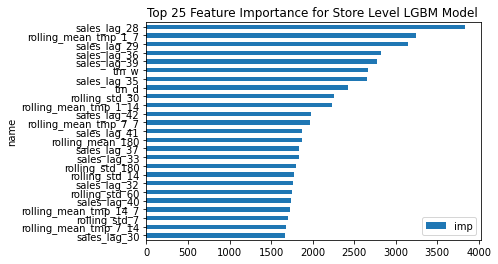

In [11]:
import matplotlib.pyplot as plt

feature_imp_df = pd.DataFrame({'name':m_lgb.feature_name(),
                               'imp':m_lgb.feature_importance()}).sort_values('imp',ascending=False).head(25)
dataFrame  = pd.DataFrame(data = feature_imp_df);
dataFrame.sort_values('imp',inplace=True)
dataFrame.plot.barh(x='name', y='imp', title="Top 25 Feature Importance for Store Level LGBM Model ");
plt.savefig(os.path.join(base_dir_path, f'plots/LGBM_predictor_feat_imp_store.png'), bbox_inches='tight')

plt.show(block=True);

In [25]:
model_name = base_dir_path + '/preprocessed_data/non_recur_model_store.bin'
pickle.dump(m_lgb, open(model_name, 'wb'))


indice = test_features_df.index.tolist()
prediction = pd.DataFrame({'y_pred' : m_lgb.predict(test_features_df[train_model_var])})


prediction.index = indice



In [18]:
prediction


,y_pred
730,3348.231598
731,4745.313447
732,5233.005423
733,4300.887361
734,3846.036282
735,3814.427365
736,3823.916000
737,4221.787648
738,5528.505045
739,5553.872492


In [35]:
prediction_df = pd.concat([test_features_df['date'], prediction], axis=1)
prediction_df['model'] = 'LGBM'
prediction_df = prediction_df.rename({'y_pred': 'pred_sales'}, axis=1)
prediction_df

,date,pred_sales,model
730,2016-01-01,3348.231598,LGBM
731,2016-01-02,4745.313447,LGBM
732,2016-01-03,5233.005423,LGBM
733,2016-01-04,4300.887361,LGBM
734,2016-01-05,3846.036282,LGBM
735,2016-01-06,3814.427365,LGBM
736,2016-01-07,3823.916000,LGBM
737,2016-01-08,4221.787648,LGBM
738,2016-01-09,5528.505045,LGBM
739,2016-01-10,5553.872492,LGBM


In [36]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(test_features_df['sales'], prediction_df['pred_sales'], squared=False)
rms 

339.5966688046362

In [40]:
prediction_df.to_csv(os.path.join(base_dir_path, f'predictions/nonrec_lgbm_store_prediction.csv'), index = False)

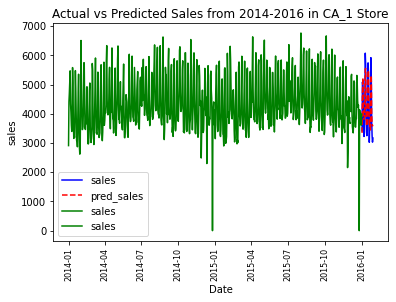

In [77]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.plot( 'date', 'sales', data=test_features_df, color='blue')
plt.plot( 'date', 'pred_sales', data=prediction_df, color='red', linestyle='dashed')
plt.plot( 'date', 'sales', data=train_df, color='green')
plt.plot( 'date', 'sales', data=validation_df, color='green')

plt.legend()
plt.xticks(fontsize=8, rotation=90)
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Actual vs Predicted Sales from 2014-2016 in CA_1 Store')
plt.savefig(os.path.join(base_dir_path, f'plots/LGBM_predictor_{agg_level}_entire_dataset.png'), bbox_inches='tight')
plt.show()



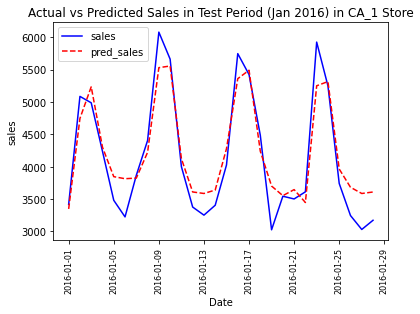

In [76]:
plt.plot( 'date', 'sales', data=test_features_df, color='blue')
plt.plot( 'date', 'pred_sales', data=prediction_df, color='red', linestyle='dashed')

plt.legend()
plt.xticks(fontsize=8, rotation=90)
plt.xlabel('Date')
plt.ylabel('sales')
plt.title('Actual vs Predicted Sales in Test Period (Jan 2016) in CA_1 Store')
plt.savefig(os.path.join(base_dir_path, f'plots/LGBM_predictor_{agg_level}.png'), bbox_inches='tight')
plt.show()
